# In-class assignment: Convolution and filtering
## 02.01.2019

In project 1, we discussed the geometry of image formation, and how to map from coordinates in the real world to coordinates in the image.  Now, we switch gears and start to think about what do we do with images once we have them?  

An image should be viewed as a function.  It takes two arguments ($u$ and $v$) and outputs an intensity $I$ (or perhaps a triple $I_r$, $I_g$, and $I_b$).  We can do all the normal things that we would do with functions, like adding, subtracting, multiplying by a constant, rotation and translation around an origin, and so on, and each of these operations will be useful.  However, when we think of *image processing*, the thing that comes to mind is usually the process of filtering.  For example, given a noisy image like this one:

<img src='noisy_big_chief.jpeg'>

How can we reduce the noise level?  E.g. how can we recover the true function $I(u,v)$, when the thing that we measure is $\hat{I}(u,v) = I(u,v) + \epsilon(u,v)$, $\epsilon(u,v) \sim \mathcal{N}(0,\sigma)$? 

The common approach is to take a moving average: for each pixel, approximate $I(u,v)$ with 
$$
I(u,v) \approx \frac{1}{n} \sum_{j,k} \hat{I}(u+j,v+k),
$$
where $j$ and $k$ are indices of pixels in a neighborhood, and $n$ is the number of pixels in the neighborhood.  For example, if we assume a neighborhood as being the immediately adjacent pixels, then $j,k\in\{-1,0,1\}$ and $n=9$.  This moving average is a special case of a more general operations called *convolution*, which is defined as 
$$
(g \star h)(u,v) = \sum_{j,k} h(j,k) g(u-j,v-k),
$$
where $g$ is a 2D image, and $h$ is called the *kernel*.  For our previous neighborhood moving average example, what is the kernel?  **Please generate some code that applies convolution of an arbitrary image with an arbitrary array, then compute the convolution of an image of your choice with this kernel**.

In [1]:
import numpy as np

def convolve(g,h):
    # The radius in pixels of the kernel about its central point
    radius = h.shape[0] // 2
    out = np.zeros_like(g)
    h180 = h[::-1,::-1]
    # Loop over rows: y
    for v in range(radius, g.shape[0] - radius):
        # Loop over columns: x
        for u in range(radius, g.shape[1] - radius):
            # Compute element-wise product of the kernel with the current
            # image chunk, sum the result and set the current pixel to
            # that value
            out[v, u] = np.sum(g[v-radius:v+radius+1, u-radius:u+radius+1] * h180)
    return out

In [2]:
# Test averaging filter

import matplotlib.pyplot as plt

img_color = plt.imread('lazy_cat_small.jpg')
I_gray = img_color.mean(axis=2)

n = 15
h_mean = np.ones((n, n))
h_mean /= h_mean.size

img_smoothed = convolve(I_gray, h_mean)

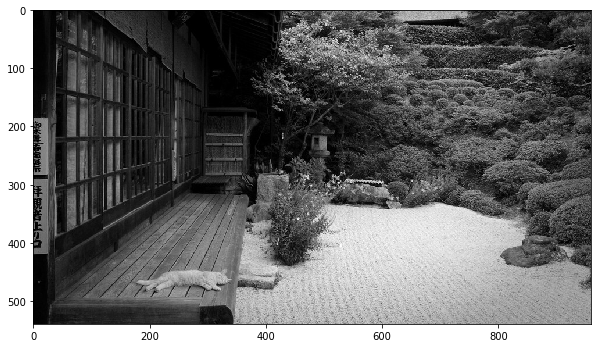

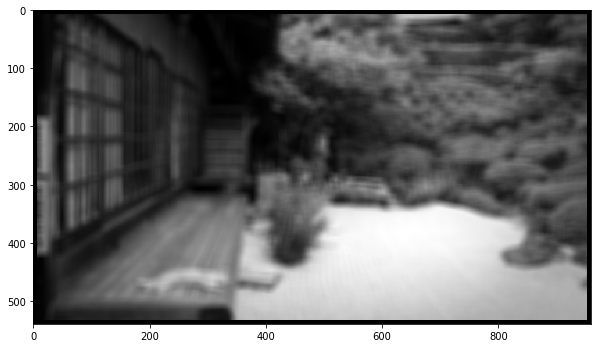

In [3]:
# Plot before and after
plt.figure(figsize=(10,10))
plt.imshow(I_gray, cmap="gray")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(img_smoothed, cmap="gray")
plt.show()

This particular kernel is called the box kernel, and it performs smoothing.  However, there are other choices for performing smoothing as well.  For example, for eliminating normally-distributed noise (i.e. white noise), the optimal kernel for recovering the denoised signal is called a Gaussian kernel.  Unsurprisingly, this kernel looks like a Gaussian:
$$
h_{gauss}(j,k;\sigma) = Z \exp -\frac{j^2 + k^2}{2\sigma^2},
$$
where $Z$ is a normalizing constant computed after the fact such that the sum of the kernel is unity.  This normalization is important as it keeps the smoothing filter from lightening or darkening the overall image.  **Generate a function that produces a gaussian kernel of arbitrary size and with arbitrary $\sigma$.  Convolve this kernel with the same image as above (for a few choices of $\sigma$ and neighborhood size), and think about any differences that appear**.

In [6]:
def get_gaussian_kernel(n, sigma):
    if not n % 2:
        raise ValueError(f"Kernel size must be odd: {n}")
    
    mean = n // 2
    h = np.empty((n, n))
    for j in range(n):
        for k in range(n):
            h[k, j] = np.exp(-((j - mean)**2 + (k - mean)**2) / (2.0 * sigma**2))
    h /= h.sum()
    return h

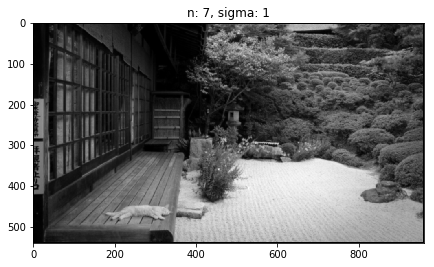

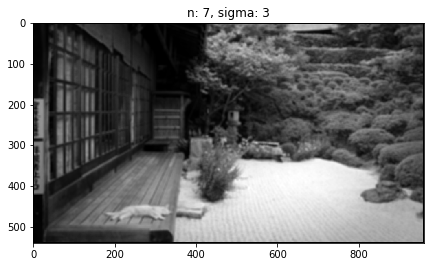

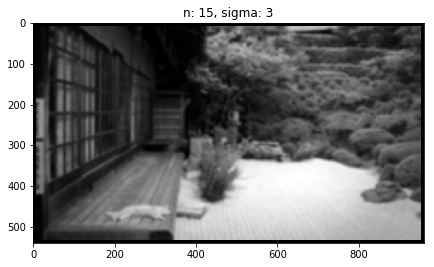

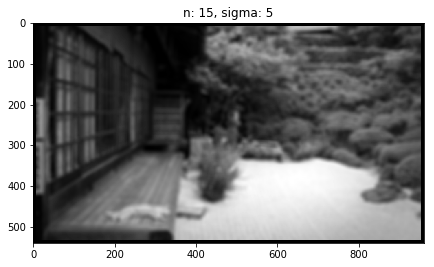

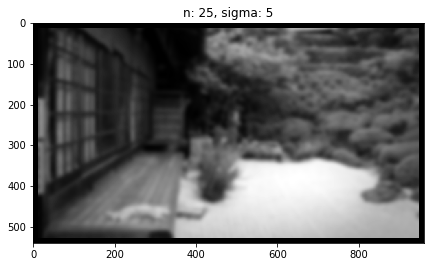

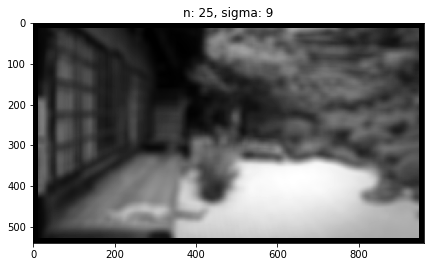

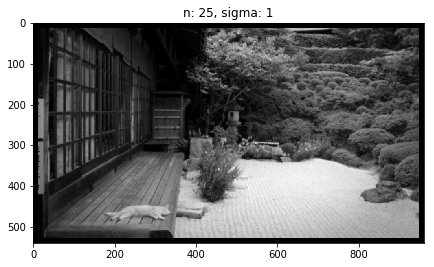

In [7]:
hs = []
hs.append((7, 1, get_gaussian_kernel(7, 1)))
hs.append((7, 3, get_gaussian_kernel(7, 3)))
hs.append((15, 3, get_gaussian_kernel(15, 3)))
hs.append((15, 5, get_gaussian_kernel(15, 5)))
hs.append((25, 5, get_gaussian_kernel(25, 5)))
hs.append((25, 9, get_gaussian_kernel(25, 9)))
hs.append((25, 1, get_gaussian_kernel(25, 1)))

for hi in hs:
    n, s, h = hi
    plt.figure(figsize=(7, 7))
    plt.imshow(convolve(I_gray, h), cmap="gray")
    plt.title(f"n: {n}, sigma: {s}")
    plt.show()

Convolution can be used for things besides smoothing as well, depending on the choice of kernel.  One popular use (and one that we will use extensively) is convolution for computing *gradients*, the spatial derivative of an image.  It will become obvious why this is useful after you do it.  There are many choices of kernel that can be used to compute gradients, but the most common is a so-called Sobel operator:
$$
S_u = \begin{bmatrix} -1 & 0 & 1\\
                      -2 & 0 & 2\\
                      -1 & 0 & 1 \end{bmatrix}.
$$
**Convolve this kernel with your chosen image, and discuss what features this seems to accentuate.  Also try convolving the transpose of the kernel (which is S_v).  What features does the transpose highlight?**.
                     

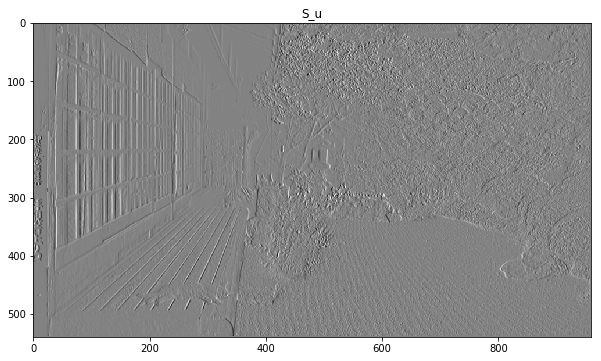

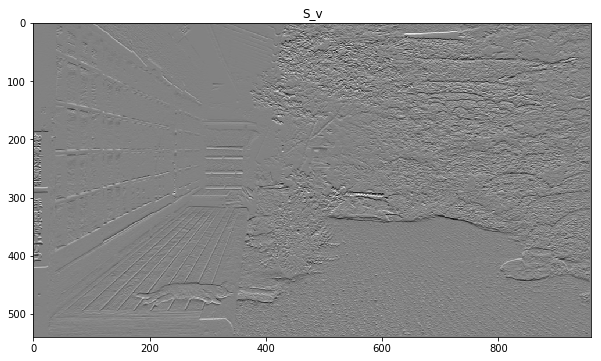

In [37]:
s_u = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

s_v = s_u.T

plt.figure(figsize=(10, 10))
plt.imshow(convolve(I_gray, s_u), cmap="gray")
plt.title("S_u")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(convolve(I_gray, s_v), cmap="gray")
plt.title("S_v")
plt.show()

**$S_u$ and $S_v$, when convolved with the image array, highlight the vertical and horizontal edges respectively.**